#  Outlier Detection: Osun State 2023 Presidential Election Data Using Geospatial Analysis


- #### Dataset Preparation

In [1]:
# import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
import geopandas as gpd
from IPython.display import display, HTML
import contextily as ctx

In [2]:
# merge the seperate two files

df1=pd.read_csv('C:/Users/WOYES/Desktop/HNG/OSUN_crosschecked.csv')   # contains information about polling units without their latitude and longitude
df2=pd.read_csv('C:/Users/WOYES/Desktop/HNG/latlong.csv')             # contains information about the latitude and longitude of each polling unit

df = df1.merge(df2, on='PU-Name', how='inner')
df.head()

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,...,APC,LP,PDP,NNPP,Results_File,ward_name,local_government_name,state_name,location.latitude,location.longitude
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,...,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,IWARA,ATAKUMOSA EAST,OSUN,7.466182,4.678075
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",245,881,True,-1,False,...,40,11,175,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,IWARA,ATAKUMOSA EAST,OSUN,7.586975,4.629450
2,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-004,"METHODIST PRY. SCHOOL, AYETORO",117,308,True,-1,False,...,14,3,99,1,https://inec-cvr-cache.s3.eu-west-1.amazonaws....,IWARA,ATAKUMOSA EAST,OSUN,7.846332,4.487902
3,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-007,OPEN SPACE ODO-IWARA,187,538,True,-1,False,...,25,4,155,0,https://docs.inecelectionresults.net/elections...,IWARA,ATAKUMOSA EAST,OSUN,7.540318,4.825199
4,OSUN,ATAKUMOSA EAST,IGANGAN,29-01-02-001,"N.U.D PRY. SCHOL, IGANGAN",187,558,True,-1,False,...,22,0,161,0,https://docs.inecelectionresults.net/elections...,IGANGAN,ATAKUMOSA EAST,OSUN,7.546745,3.788141


In [3]:
# rename location.latitude and location.longitude
df.rename(columns={'location.latitude':'latitude','location.longitude':'longitude'}, inplace=True)

In [4]:
# check the total features in the dataset
df.columns

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'Results_Found', 'Transcription_Count',
       'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP', 'Results_File', 'ward_name',
       'local_government_name', 'state_name', 'latitude', 'longitude'],
      dtype='object')

In [5]:
df.shape

(2281, 24)

Let's select some valuable features from the dataset for our analysis

In [6]:
# subset the dataset
data = df.loc[:, ['State','LGA','Ward','PU-Code','PU-Name','APC','LP','PDP','NNPP','latitude','longitude']].copy()
data.head()

,State,LGA,Ward,PU-Code,PU-Name,APC,LP,PDP,NNPP,latitude,longitude
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,44,273,0,0,7.466182,4.678075
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",40,11,175,1,7.586975,4.629450
2,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-004,"METHODIST PRY. SCHOOL, AYETORO",14,3,99,1,7.846332,4.487902
3,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-007,OPEN SPACE ODO-IWARA,25,4,155,0,7.540318,4.825199
4,OSUN,ATAKUMOSA EAST,IGANGAN,29-01-02-001,"N.U.D PRY. SCHOL, IGANGAN",22,0,161,0,7.546745,3.788141


In [7]:
# check for percentages of null values in each columns
(data.isnull().sum()/len(data)*100)

State         0.000000
LGA           0.000000
Ward          0.000000
PU-Code       0.000000
PU-Name       0.000000
APC           0.000000
LP            0.000000
PDP           0.000000
NNPP          0.000000
latitude     11.617712
longitude    11.617712
dtype: float64

The percentage of null values in both latitude and longitude column is almost 12. Let's simply drop those columns 

In [8]:
# drop null values 
data.dropna(subset=['latitude'], inplace=True)

In [9]:
# new dataset shape
data.shape

(2016, 11)

In [10]:
# recheck for null values
data.isnull().sum()

State        0
LGA          0
Ward         0
PU-Code      0
PU-Name      0
APC          0
LP           0
PDP          0
NNPP         0
latitude     0
longitude    0
dtype: int64

Our data is now free of any null values

- #### Neighbour Identification

We will use the distance_matrix function from scipy.spatial to compute the distances between all pairs of polling units.

In [11]:
# Reset index to ensure sequential indexing
data.reset_index(drop=True, inplace=True)

# Extract latitude and longitude columns
lat_lon = data[['latitude', 'longitude']].values

# Calculate the distance matrix between all polling units
dist_matrix = distance_matrix(lat_lon, lat_lon)
dist_matrix

array([[0.        , 0.13021195, 0.42506374, ..., 0.34232331, 0.34232331,
        0.34232331],
       [0.13021195, 0.        , 0.29546894, ..., 0.21217341, 0.21217341,
        0.21217341],
       [0.42506374, 0.29546894, 0.        , ..., 0.091993  , 0.091993  ,
        0.091993  ],
       ...,
       [0.34232331, 0.21217341, 0.091993  , ..., 0.        , 0.        ,
        0.        ],
       [0.34232331, 0.21217341, 0.091993  , ..., 0.        , 0.        ,
        0.        ],
       [0.34232331, 0.21217341, 0.091993  , ..., 0.        , 0.        ,
        0.        ]])

- #### Outlier Score Calculation

For each party (APC, LP, PDP, NNPP), we would calculate their outlier score as the absolute difference between the votes at the current polling unit and the mean votes of its neighbours.

In [12]:
# Define the radius for neighbours (in kilometers)
radius_km = 1.0

# Create a list to store the outlier scores and neighbour information
results = []

# Iterate over each polling unit to calculate the outlier scores
for index, row in data.iterrows():
    # Find neighbouring polling units within the specified radius
    neighbours = data[(dist_matrix[index] <= radius_km) & (data.index != index)]

    # Calculate the outlier score for each party
    apc_outlier = abs(row['APC'] - neighbours['APC'].mean()) if not neighbours.empty else 0
    lp_outlier = abs(row['LP'] - neighbours['LP'].mean()) if not neighbours.empty else 0
    pdp_outlier = abs(row['PDP'] - neighbours['PDP'].mean()) if not neighbours.empty else 0
    nnpp_outlier = abs(row['NNPP'] - neighbours['NNPP'].mean()) if not neighbours.empty else 0

    # Store the results
    results.append({
        'PU-Name': row['PU-Name'],
        'Latitude': row['latitude'],
        'Longitude': row['longitude'],
        'APC_outlier': apc_outlier,
        'LP_outlier': lp_outlier,
        'PDP_outlier': pdp_outlier,
        'NNPP_outlier': nnpp_outlier,
        'Neighbour_polls': neighbours['PU-Name'].tolist()
    })

# Convert the results list to a DataFrame
outlier_scores = pd.DataFrame(results)

# Display the outlier scores
outlier_scores.head()

,PU-Name,Latitude,Longitude,APC_outlier,LP_outlier,PDP_outlier,NNPP_outlier,Neighbour_polls
0,TOWN HALL IWARA,7.466182,4.678075,53.480877,266.240694,98.483427,0.458440,"[L.A. SCHOOL, IWIKUN, METHODIST PRY. SCHOOL, A..."
1,"L.A. SCHOOL, IWIKUN",7.586975,4.629450,57.471698,4.108618,76.637940,0.542070,"[TOWN HALL IWARA, METHODIST PRY. SCHOOL, AYETO..."
2,"METHODIST PRY. SCHOOL, AYETORO",7.846332,4.487902,83.655243,3.909974,0.391304,0.540153,"[TOWN HALL IWARA, L.A. SCHOOL, IWIKUN, OPEN SP..."
3,OPEN SPACE ODO-IWARA,7.540318,4.825199,72.520163,2.903522,56.653395,0.458908,"[TOWN HALL IWARA, L.A. SCHOOL, IWIKUN, METHODI..."
4,"N.U.D PRY. SCHOL, IGANGAN",7.546745,3.788141,79.721411,7.547445,63.266423,0.467762,"[TOWN HALL IWARA, L.A. SCHOOL, IWIKUN, METHODI..."


In [13]:
outlier_scores.to_excel('Osunexcel2023.xlsx')

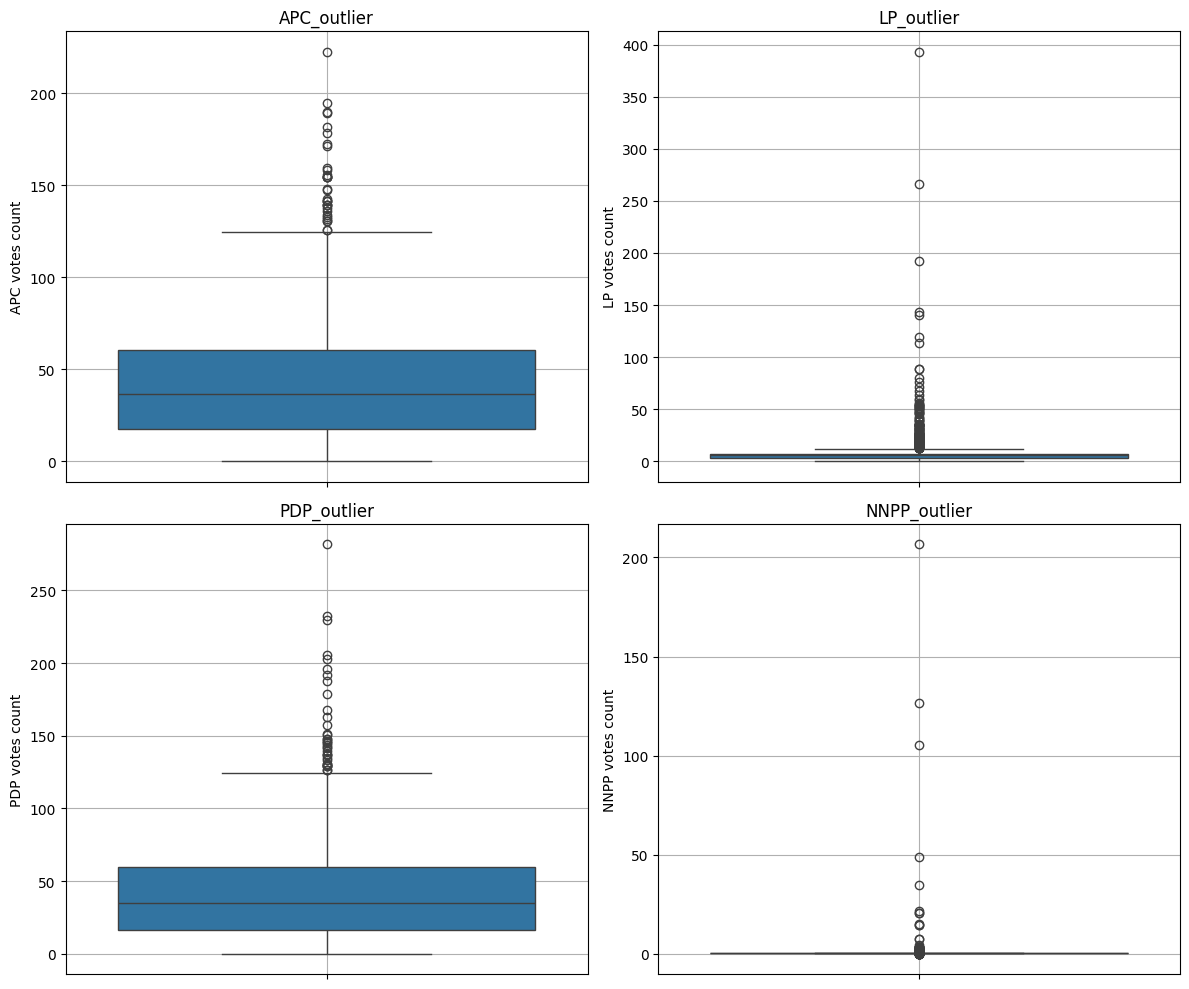

In [14]:
# Set up the matplotlib figure
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot each scatter plot
sns.boxplot(ax=axs[0, 0], data=outlier_scores['APC_outlier'])
axs[0, 0].set_title('APC_outlier')
axs[0,0].set_ylabel('APC votes count')
axs[0, 0].grid(True)

sns.boxplot(ax=axs[0, 1], data=outlier_scores['LP_outlier'])
axs[0, 1].set_title('LP_outlier')
axs[0,1].set_ylabel('LP votes count')
axs[0, 1].grid(True)

sns.boxplot(ax=axs[1, 0], data=outlier_scores['PDP_outlier'])
axs[1, 0].set_title('PDP_outlier')
axs[1,0].set_ylabel('PDP votes count')
axs[1, 0].grid(True)


sns.boxplot(ax=axs[1, 1], data=outlier_scores['NNPP_outlier'])
axs[1, 1].set_title('NNPP_outlier')
axs[1,1].set_ylabel('NNPP votes count')
axs[1, 1].grid(True)



# Adjust the layout
plt.tight_layout()

plt.savefig('election_outliers.png')

# Display the plots
plt.show()



- #### Sorting

Let's sort our dataset to know the top three outlier places

In [15]:
out = outlier_scores.drop(columns=['Neighbour_polls'])

# Sort the dataset by the outlier scores for each party
sorted_apc = out.sort_values(by='APC_outlier', ascending=False).head(3)
sorted_lp = out.sort_values(by='LP_outlier', ascending=False).head(3)
sorted_pdp = out.sort_values(by='PDP_outlier', ascending=False).head(3)
sorted_nnpp = out.sort_values(by='NNPP_outlier', ascending=False).head(3)



# Display the DataFrames
print('\033[1m' + 'Top 3 APC Outliers:' + '\033[0m')
display(HTML(sorted_apc.to_html()))
display(HTML('<hr style="height:3px;border:none;color:#333;background-color:#333;" />'))  # Horizontal line separator

print('\033[1m' + 'Top 3 PDP Outliers:' + '\033[0m')
display(HTML(sorted_pdp.to_html()))
display(HTML('<hr style="height:3px;border:none;color:#333;background-color:#333;" />'))  # Horizontal line separator

print('\033[1m' + 'Top 3 LP Outliers:' + '\033[0m')
display(HTML(sorted_lp.to_html()))
display(HTML('<hr style="height:3px;border:none;color:#333;background-color:#333;" />'))  # Horizontal line separator

print('\033[1m' + 'Top 3 NNPC Outliers:' + '\033[0m')
display(HTML(sorted_pdp.to_html()))

Top 3 APC Outliers:


,PU-Name,Latitude,Longitude,APC_outlier,LP_outlier,PDP_outlier,NNPP_outlier
261,"L.A. SCHOOL, EESADEE",7.778738,4.582862,222.554931,6.914154,31.561063,0.459377
755,"OGUNSUA GRAM. SCHOOL, ESUYARE",7.480880,4.525433,194.664457,36.134625,38.638450,0.458950
323,OPEN SPACE IN FRONT OF BAALE ILE ARANYIN( ARANYIN SQUARE,7.734928,4.443937,189.563042,6.897907,75.535988,0.459418


Top 3 PDP Outliers:


,PU-Name,Latitude,Longitude,APC_outlier,LP_outlier,PDP_outlier,NNPP_outlier
337,"OWODE COMM. PRY SCHOOL,",7.715233,4.486008,119.611111,140.187054,281.753313,1.542304
1964,ANUOLU JUNCTION,7.724950,4.442955,0.472718,10.117797,232.704742,0.458950
993,SECRETARIAT,8.011101,4.912681,46.702393,4.006764,229.962539,0.534860


Top 3 LP Outliers:


,PU-Name,Latitude,Longitude,APC_outlier,LP_outlier,PDP_outlier,NNPP_outlier
465,"BEULAH BAPT. SCHOOL, EJIGBO",7.907559,4.316765,96.596716,393.285274,97.671626,1.539251
0,TOWN HALL IWARA,7.466182,4.678075,53.480877,266.240694,98.483427,0.458440
5,"APOSTOLIC PRY. SCHOOL, OKO-AGO",7.469135,4.542204,94.482917,192.214176,98.431413,0.458950


Top 3 NNPC Outliers:


,PU-Name,Latitude,Longitude,APC_outlier,LP_outlier,PDP_outlier,NNPP_outlier
337,"OWODE COMM. PRY SCHOOL,",7.715233,4.486008,119.611111,140.187054,281.753313,1.542304
1964,ANUOLU JUNCTION,7.724950,4.442955,0.472718,10.117797,232.704742,0.458950
993,SECRETARIAT,8.011101,4.912681,46.702393,4.006764,229.962539,0.534860


In [16]:
sorted_apc = out.sort_values(by='APC_outlier', ascending=False)
sorted_lp = out.sort_values(by='LP_outlier', ascending=False)
sorted_pdp = out.sort_values(by='PDP_outlier', ascending=False)
sorted_nnpp = out.sort_values(by='NNPP_outlier', ascending=False)

In [17]:
sorted_apc.to_excel('sorted_apc.xlsx')
sorted_lp.to_excel('sorted_lp.xlsx')
sorted_pdp.to_excel('sorted_pdp.xlsx')
sorted_nnpp.to_excel('sorted_nnpp.xlsx')